In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = '../data/processed/concatenated_data_csv/split_0'

# betas_train_path = f'{data_dir}/betas_train.csv'
# se_train_path = f'{data_dir}/se_train.csv'
# betas_val_path = f'{data_dir}/betas_validate.csv'
# se_val_path = f'{data_dir}/se_validate.csv'

In [4]:
labfs_train = pd.read_csv(f"{data_dir}/labfs_train.csv")
labfs_validate = pd.read_csv(f"{data_dir}/labfs_validate.csv")

labfs_cols = [v for v in labfs_train.columns if 'cv_idx' not in v]

labfs_train = labfs_train[labfs_cols].set_index('file_path')
labfs_validate = labfs_validate[labfs_cols].set_index('file_path')

labfs_validate_assignments = labfs_validate.copy()

In [5]:
tot_clusters = 61

In [6]:
from sklearn.metrics import adjusted_rand_score
import numpy as np

In [7]:
calc_centroid = lambda in_df : in_df.groupby('cluster_num').mean()

In [8]:
start_centroid = calc_centroid(labfs_train)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [17]:
# labfs_train

In [ ]:
def fraction_close(group):
    cluster_id = group.name
    centroid = group.mean().values
    X = group.values
    dists = np.linalg.norm(X - centroid, axis=1)
    threshold = max(dists)*0.8
    return np.mean(dists <= threshold)

# fraction_per_cluster = labfs_train.groupby('cluster_num').apply(fraction_close)

/tmp/ipykernel_10487/936689429.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fraction_per_cluster = labfs_train.groupby('cluster_num').apply(fraction_close)


In [43]:
# plt.scatter(x = fraction_per_cluster.index, y = fraction_per_cluster)

In [44]:
metric_tracking_assigned = []
metric_tracking_true = []

for iter_num, new_cluster_point in enumerate(labfs_validate.index):

    # add cluster assignment
    assigned_cluster = np.random.randint(tot_clusters)
    true_cluster = labfs_validate.loc[new_cluster_point,'cluster_num']
    
    labfs_validate_assignments.loc[new_cluster_point,'cluster_num'] = assigned_cluster

    true_labels = pd.concat([labfs_train,labfs_validate[:iter_num+1]])
    true_centroids = calc_centroid(true_labels)

    assigned_labels = pd.concat([labfs_train,labfs_validate_assignments[:iter_num+1]])
    assigned_centroids = calc_centroid(assigned_labels)

    # plt.scatter(x = fraction_per_cluster.index, y = fraction_per_cluster)

    # calculate metric
    metric_val_dict_assigned = {}
    metric_val_dict_true = {}

    true_cs = np.diag(euclidean_distances(start_centroid.values, true_centroids.values))
    assigned_cs = np.diag(euclidean_distances(start_centroid.values, assigned_centroids.values))

    metric_val_dict_assigned['centroid_similarity'] = np.median(assigned_cs)
    metric_val_dict_true['centroid_similarity'] = np.median(true_cs)

    metric_val_dict_assigned['centroid_similarity_min'] = np.min(assigned_cs)
    metric_val_dict_true['centroid_similarity_min'] = np.min(true_cs)

    metric_val_dict_assigned['centroid_similarity_max'] = np.max(assigned_cs)
    metric_val_dict_true['centroid_similarity_max'] = np.max(true_cs)

    fraction_per_cluster_ass = assigned_labels.groupby('cluster_num').apply(fraction_close)
    fraction_per_cluster_true = true_labels.groupby('cluster_num').apply(fraction_close)

    metric_val_dict_assigned['frac_per_cluster'] = np.median(fraction_per_cluster_ass)
    metric_val_dict_true['frac_per_cluster'] = np.median(fraction_per_cluster_true)

    metric_val_dict_assigned['frac_per_cluster_min'] = np.min(fraction_per_cluster_ass)
    metric_val_dict_true['frac_per_cluster_min'] = np.min(fraction_per_cluster_true)

    metric_val_dict_assigned['frac_per_cluster_max'] = np.max(fraction_per_cluster_ass)
    metric_val_dict_true['frac_per_cluster_max'] = np.max(fraction_per_cluster_true)

    # append metric
    metric_tracking_assigned.append(metric_val_dict_assigned)
    metric_tracking_true.append(metric_val_dict_true)

    # break

/tmp/ipykernel_10487/4270434874.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fraction_per_cluster_ass = assigned_labels.groupby('cluster_num').apply(fraction_close)
/tmp/ipykernel_10487/4270434874.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fraction_per_cluster_true = true_labels.groupby('cluster_num').apply(fraction_close)
/tmp/ipykernel_10487/4270434874.py:36: DeprecationWarning: DataFram

Text(0.5, 0, 'increment point id')

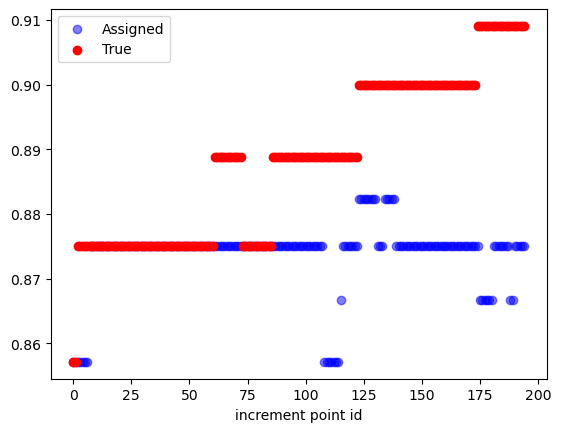

In [48]:
df_assigned = pd.DataFrame(metric_tracking_assigned)
df_true = pd.DataFrame(metric_tracking_true)

plt.scatter(x=df_assigned.index, y=df_assigned['frac_per_cluster'], color='b', alpha=0.5, label='Assigned')
# plt.scatter(x=df_assigned.index, y=df_assigned['centroid_similarity_min'], color='b', alpha=0.5, label='Assigned')
# plt.scatter(x=df_assigned.index, y=df_assigned['frac_per_cluster_min'], color='b', alpha=0.5, label='Assigned',marker='+')

# plt.errorbar(x=df_assigned.index, y=df_assigned['centroid_similarity'], color='b', alpha=0.5, label='Assigned',
#              yerr = [yl_as, yu_as])

plt.scatter(x=df_true.index, y=df_true['frac_per_cluster'], color='r', label='True')
# plt.scatter(x=df_true.index, y=df_true['frac_per_cluster_min'], color='r', label='True')

# plt.scatter(x=df_true.index, y=df_true['centroid_similarity_min'], color='r', label='True')
# plt.scatter(x=df_true.index, y=df_true['centroid_similarity_max'], color='r', label='True',marker='+')

plt.legend()
# plt.title('median euclidean_distances from cluster centroids\n on random assignment vs ground truth')
plt.xlabel('increment point id')
# plt.ylabel('euclidean distance')

Text(0, 0.5, 'euclidean distance')

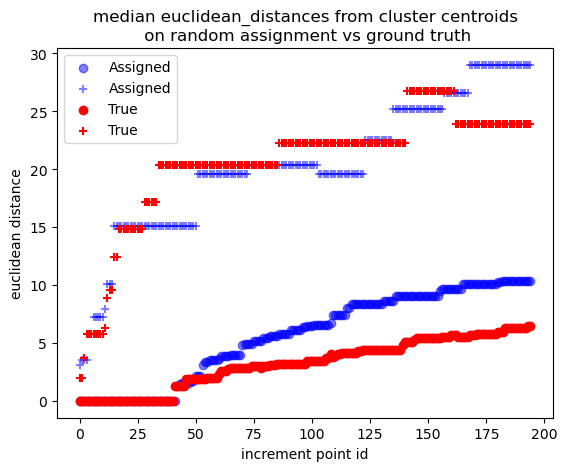

In [ ]:
df_assigned = pd.DataFrame(metric_tracking_assigned)
df_true = pd.DataFrame(metric_tracking_true)

yl_as = df_assigned['centroid_similarity'] - df_assigned['centroid_similarity_min']
yu_as = df_assigned['centroid_similarity_max'] - df_assigned['centroid_similarity']
plt.scatter(x=df_assigned.index, y=df_assigned['centroid_similarity'], color='b', alpha=0.5, label='Assigned')
# plt.scatter(x=df_assigned.index, y=df_assigned['centroid_similarity_min'], color='b', alpha=0.5, label='Assigned')
plt.scatter(x=df_assigned.index, y=df_assigned['centroid_similarity_max'], color='b', alpha=0.5, label='Assigned',marker='+')

# plt.errorbar(x=df_assigned.index, y=df_assigned['centroid_similarity'], color='b', alpha=0.5, label='Assigned',
#              yerr = [yl_as, yu_as])

plt.scatter(x=df_true.index, y=df_true['centroid_similarity'], color='r', label='True')
# plt.scatter(x=df_true.index, y=df_true['centroid_similarity_min'], color='r', label='True')
plt.scatter(x=df_true.index, y=df_true['centroid_similarity_max'], color='r', label='True',marker='+')

plt.legend()
plt.title('median euclidean_distances from cluster centroids\n on random assignment vs ground truth')
plt.xlabel('increment point id')
plt.ylabel('euclidean distance')

In [157]:
# plt.scatter(x = list(range(len(metric_tracking))),y = metric_tracking)
# plt.ylim(-1,1)

Text(0.5, 1.0, 'rand score is 0 with random increments as expected')

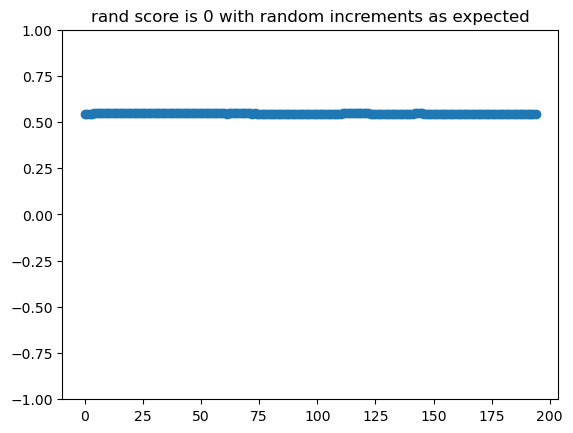

In [49]:
metric_tracking = []

for iter_num, new_cluster_point in enumerate(labfs_validate.index):

    # add cluster assignment
    assigned_cluster = np.random.randint(tot_clusters)
    labfs_validate_assignments.loc[new_cluster_point,'cluster_num'] = assigned_cluster

    labels_true = list(labfs_train['cluster_num']) + list(labfs_validate['cluster_num'])
    labels_pred = list(labfs_train['cluster_num']) + list(labfs_validate_assignments['cluster_num'])

    # labels_true = list(labfs_validate['cluster_num'])
    # labels_pred = list(labfs_validate_assignments['cluster_num'])

    metric_tracking.append(adjusted_rand_score(labels_true, labels_pred))

plt.scatter(x = list(range(len(metric_tracking))),y = metric_tracking)
plt.ylim(-1,1)
plt.title('rand score is 0 with random increments as expected')